# Evaluating model and interpret the classification results

In [1]:
import torchray
import torch
import attr
from pathlib import Path
from torchvision import datasets, transforms
from torchray.benchmark import get_example_data, plot_example
from torchvision import models
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics as sk_metrics
from torchray.attribution.common import Probe, get_module
from torchray.attribution.grad_cam import grad_cam
from torchray.attribution.grad_cam import gradient_to_grad_cam_saliency
from PIL import Image

In [2]:
@attr.s(auto_attribs=True)
class DataPreparation:
    data_dir: Path
    device: str = attr.ib(default=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), init=False)

    @staticmethod
    def data_transformations():
        data_transforms = {
            'test': transforms.Compose([
                transforms.CenterCrop((200, 1500)),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        return data_transforms
    
    def create_dataloaders(self, batch_size, shuffle, num_workers):
        data_transforms = self.data_transformations()
        
        image_datasets = {
            'test': datasets.ImageFolder(self.data_dir, data_transforms['test'])
        }
        dataloaders = {
            'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        }
        dataset_sizes = {
            'test': len(image_datasets['test'])
        }
        return dataloaders, dataset_sizes


In [3]:
data_prep = DataPreparation('../data/figures/test')
data, size = data_prep.create_dataloaders(16, False, 4)

In [4]:
# model_path = Path().cwd().parents[0] / "models/resnet50_d_28_t_15_49.pth"
# model_path = Path().cwd().parents[0] / "models/resnet50_d_29_t_02_34.pth"
# model_path = Path().cwd().parents[0] / "models/resnet50_d_29_t_13_14.pth"
# model_path = Path().cwd().parents[0] / "models/resnet50_d_29_t_14_58.pth"
# model_path = Path().cwd().parents[0] / "models/resnet50_d_29_t_17_14.pth" # without pretrained only one learning rate
model_path = Path().cwd().parents[0] / "models/resnet50_d_29_t_18_06.pth" # with pretrained only one learning rate

In [5]:
model = torch.load(model_path)
model.eval();

In [6]:
def deprocess(image):
    transform = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [7]:
i = 0
for inputs, labels in data['test']:
    inputs = inputs.to(0)
    labels = labels.to(0)
    x = inputs
    break
#     x.requires_grad_();
#     scores = model(x)
#     score_max_index = scores.argmax(dim=1)
#     score_max = scores[:, score_max_index]
#     score_max.backward(torch.ones_like(score_max))
#     saliency, _ = torch.max(x.grad.data.abs(),dim=1)
    
#     for index in range(len(saliency)): 
#         plt.figure()
#         img1 = plt.imshow(saliency[index].cpu().numpy(), cmap=plt.cm.hot, alpha=.7);
#         img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4);
#         plt.axis('off')
#         if labels[index] == 0:
#             label = "abnormal"
#         else:
#             label = "normal"
#         plt.savefig(f"../saliency_maps/pretrain_false_1lr/{label}/{i}_{index}.png")
        
#     i += 1

In [8]:
x.size()

torch.Size([16, 3, 224, 224])

In [9]:
x.requires_grad_();
scores = model(x)

In [10]:
print(f"Scores\tLabels\n{scores}\t{labels}")

Scores	Labels
tensor([[-0.6288,  0.6270],
        [-1.2222,  1.2204],
        [ 1.2031, -1.2052],
        [ 1.1488, -1.1508],
        [-1.2953,  1.2936],
        [ 1.1742, -1.1763],
        [-1.2772,  1.2754],
        [ 1.1934, -1.1955],
        [ 0.9722, -0.9743],
        [ 0.7848, -0.7868],
        [ 1.1441, -1.1461],
        [-1.1216,  1.1198],
        [ 1.1394, -1.1414],
        [ 1.1801, -1.1822],
        [ 1.1181, -1.1201],
        [ 1.2925, -1.2946]], device='cuda:0', grad_fn=<AddmmBackward>)	tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [11]:
score_max_index = scores.argmax(dim=1)
print(f"SCORE MAX INDEX: {score_max_index}")
score_max = scores[:, score_max_index]
print(f"SCORE MAX: {score_max}")

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward(torch.ones_like(score_max))
# score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(x.grad.data.abs(),dim=1)

SCORE MAX INDEX: tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
SCORE MAX: tensor([[ 0.6270,  0.6270, -0.6288, -0.6288,  0.6270, -0.6288,  0.6270, -0.6288,
         -0.6288, -0.6288, -0.6288,  0.6270, -0.6288, -0.6288, -0.6288, -0.6288],
        [ 1.2204,  1.2204, -1.2222, -1.2222,  1.2204, -1.2222,  1.2204, -1.2222,
         -1.2222, -1.2222, -1.2222,  1.2204, -1.2222, -1.2222, -1.2222, -1.2222],
        [-1.2052, -1.2052,  1.2031,  1.2031, -1.2052,  1.2031, -1.2052,  1.2031,
          1.2031,  1.2031,  1.2031, -1.2052,  1.2031,  1.2031,  1.2031,  1.2031],
        [-1.1508, -1.1508,  1.1488,  1.1488, -1.1508,  1.1488, -1.1508,  1.1488,
          1.1488,  1.1488,  1.1488, -1.1508,  1.1488,  1.1488,  1.1488,  1.1488],
        [ 1.2936,  1.2936, -1.2953, -1.2953,  1.2936, -1.2953,  1.2936, -1.2953,
         -1.2953, -1.2953, -1.2953,  1.2936, -1.2953, -1.2953, -1.2953, -1.2953],
        [-1.1763, -1.1763,  1.1742,  1.1742, -1.1763,  1.1742, -1.1763,  1.1742,
  

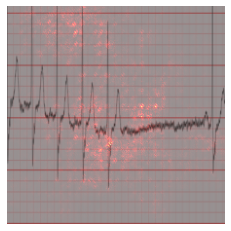

In [12]:
index = 0
# code to plot the saliency map as a heatmap
plt.figure()
img1 = plt.imshow(saliency[index].cpu().numpy(), cmap=plt.cm.hot, alpha=.7)
# plt.axis('off')
# plt.show()
img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4)
plt.axis('off')
plt.show()

In [13]:
x[index].detach().cpu().numpy().shape

(3, 224, 224)

In [14]:
x_img = deprocess(x[index].cpu())
np.transpose(x[index].detach().cpu().numpy(), (1,2,0)).shape

(224, 224, 3)

In [15]:
sal = saliency[index].cpu().numpy()

In [16]:
saliency_arr = np.array([sal, sal, sal])
saliency_arr.shape

(3, 224, 224)

In [17]:
map_sal = Image.fromarray(saliency_arr.T, 'RGB')

In [18]:
map_sal.size, x_img.size

((224, 224), (224, 224))

In [19]:
newimg1 = Image.blend(x_img, map_sal, alpha=0.5)

In [20]:
newimg1.save('example.png', 'png')

In [21]:
deprocess(x[index].cpu()).save("test.png")

In [22]:
saliency[index].mean()

tensor(0.0075, device='cuda:0')

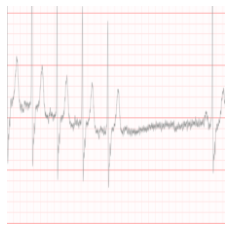

In [23]:
img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4)
plt.axis('off')
plt.show()

-------------------------------------------------------------------------------------------------

In [24]:
saliency_layer = get_module(model, model.avgpool)
probe = Probe(saliency_layer, target='output')
y = model(x)
z = y[0, labels[0]]
z.backward();

In [25]:
print(model.children)

<bound method Module.children of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256

In [ ]:
print(probe.data[0].size())
saliency = gradient_to_grad_cam_saliency(probe.data[0])
# Plots.
plot_example(x, saliency, 'grad-cam backprop', labels, save_path='saliency.pdf')

In [ ]:
# Grad-CAM backprop.
saliency = grad_cam(model, x, labels, saliency_layer=model.layer4)

# Plots.
# plot_example(x, saliency, 'grad-cam backprop', labels)

print(saliency.size())

plt.imshow(deprocess(saliency[index]).cpu().detach().numpy())
plt.axis('off')
plt.show()

--------------------------------------------------------------

# Perturbation Maps

In [28]:
from torchray.attribution.extremal_perturbation import extremal_perturbation, contrastive_reward
from torchray.utils import get_device

In [ ]:
# Extremal perturbation backprop.
index = 3
masks_1, _ = extremal_perturbation(
    model, x[index].unsqueeze(0), labels[index].int().item(),
    reward_func=contrastive_reward,
    debug=True, areas=[.08],
    perturbation="blur"
)

# Plots.
plot_example(x[index].unsqueeze(0), masks_1, 'extremal perturbation', labels[index].int().item())